In [12]:
from torch.fft import fft2, fftshift
from torch import normal, tensor
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from source import *

In [4]:
def randomize(x, y, times):
  # generate permutations
  perm = torch.bernoulli(torch.full((times, *x.shape), .5))
  perm_n = (perm == 0).to(torch.float16)

  # generate Tensor of shape (times, xH, xW)
  x_copy = x.repeat(times, 1, 1)
  y_copy = y.repeat(times, 1, 1)

  # do permutations all at once
  x_rand = x_copy * perm + y_copy * perm_n
  y_rand = x_copy * perm_n + y_copy * perm
  
  return x_rand.reshape(times, 1, *x.shape), y_rand.reshape(times, 1, *y.shape)  

In [8]:
def fourier_freq(N):
  return 2 * torch.pi * torch.arange(-(N - 1) // 2, N // 2) / N

def I(x):
  res = abs(fft2(x))**2 / (x.shape[0] * x.shape[1] * torch.var(x))
  return fftshift(res)

def k_2d_bp(N, M, hr = .2, hc = .2):
  C = 8/(torch.lgamma(tensor([.5])).exp()**2 * 4 * torch.pi**2 * hr * hc)
  omega_N = (fourier_freq(N) / hr)**2
  omega_M = (fourier_freq(M) / hc)**2
  
  omega_N = omega_N[omega_N < torch.pi**2]
  omega_M = omega_M[omega_M < torch.pi**2]

  omega_N = omega_N.reshape(omega_N.shape[0], 1)
  omega_M = omega_M.reshape(1, omega_M.shape[0])

  theta_2 = omega_N @ torch.ones(omega_N.shape[0]).reshape(1, omega_N.shape[0]) \
    + torch.ones(omega_M.shape[1]).reshape(omega_M.shape[1], 1) @ omega_M
  theta_2[theta_2 >= torch.pi**2] = torch.pi**2
  return C*(1-theta_2/torch.pi**2)


class BPKernel(nn.Module):
  def __init__(self, N, M, hr=.2, hc=.2):
      super().__init__()
      # build 2D kernel (numpy or torch) of shape (kH,kW)
      K = k_2d_bp(N, M, hr, hc)                  
      K = torch.as_tensor(K, dtype=torch.float32)

      # register it as a buffer of shape (1,1,kH,kW)
      self.register_buffer('K', K.view(1,1,*K.shape))
      # compute padding once
      self.padding = K.shape[0] // 2

  def forward(self, x):
      # x: (batch,1,H,W); same device as self.K
      return F.conv2d(x, self.K, padding=self.padding) / (x.shape[2] * x.shape[3])


class gridMA(nn.Module):
  def __init__(self, K: tensor):
    super().__init__()
    # expecting square kernel of shape (KH, KH)
    K_buffer = torch.as_tensor(K, dtype= torch.float32)

    # register K in the buffer, such that it can be moved to a CUDA device
    self.register_buffer("K", K_buffer.reshape(1,1,*K_buffer.shape))
    self.padding = K.shape[0] // 2
    
  def forward(self, N, M, T = 1):
    N_tilde = N + 2 * self.padding
    M_tilde = M + 2 * self.padding
    eps = normal(0, 1, size = (T, N_tilde, M_tilde))
    eps = eps.reshape(T,1, N_tilde, M_tilde)
    return F.conv2d(eps, self.K)

In [2]:
K = tensor([[.7, .7, .7],
            [.7, 1, .7],
           [.7, .7, .7]])

sampler = gridMA(K)
bpkernel = BPKernel(100, 100)

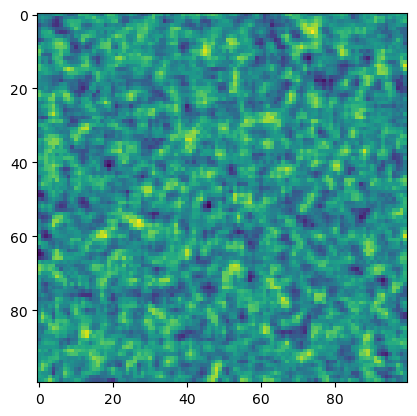

In [3]:
x = sampler(100, 100, 2)

plt.imshow(x[1][0])
plt.show()

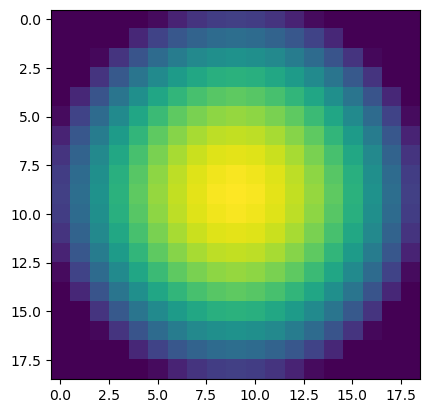

In [5]:
plt.imshow(k_2d_bp(100, 100, hr = .2, hc = .2))
plt.show()

In [6]:
# unittest for property of barlett-priestley kernel
N = 3000
M = 3000
k_2d_bp(N, M).sum()* (torch.pi**2 * 4)/(N * M)

tensor(1.0000)

In [7]:
bpkernel = BPKernel(100, 100)

x = sampler(100, 100)[0][0]
y = sampler(100, 100)[0][0]

I_x_rand, I_y_rand = randomize(I(x), I(y), 10)

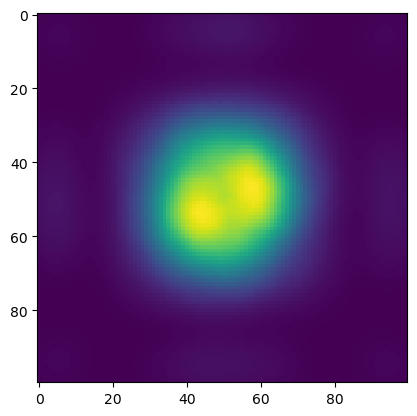

In [8]:
plt.imshow(bpkernel(I_x_rand)[4][0])
plt.show()

In [9]:
# testing if it is a true spectral density
N = 100
M = 100
bpkernel = BPKernel(N , M)
x = sampler(N, M)[0][0]
smoothed = bpkernel(I(x).view(1,1,*x.shape))
smoothed.sum() * (2*torch.pi)**2 / (N * M)

tensor(0.9844)

In [10]:
# now implementing the test
def phi_n_star(x, y, B, alpha, hr = .2, hc = .2):

  # instanciate a kernel 
  bpkernel = BPKernel(*x.shape, hr, hc).to(torch.device("cuda") if torch.cuda.is_available() else torch.float32)
  # first compute the periodogramms
  I_x = I(x).reshape(1,1, *x.shape).to(torch.device("cuda") if torch.cuda.is_available() else torch.float32)
  I_y = I(y).reshape(1,1, *x.shape).to(torch.device("cuda") if torch.cuda.is_available() else torch.float32)
  I_tilde = .5 * (I_x + I_y).to(torch.device("cuda") if torch.cuda.is_available() else torch.float32)

  # secondly compute Tn
  Tn = (bpkernel(I_x - I_tilde)**2).sum() + (bpkernel(I_x - I_tilde)**2).sum()
  Tn = Tn * (2*torch.pi)**2 / (x.shape[0] * x.shape[1])

  # then compute Tn_star
  I_tilde = I_tilde.reshape(*x.shape)
  I_x_rand, I_y_rand = randomize(I_x.reshape(*x.shape), I_y.reshape(*x.shape), B)
  
  Tn_star = (bpkernel(I_x_rand - I_tilde.repeat(B,1, 1, 1))**2).sum((2,3)) \
    + (bpkernel(I_y_rand - I_tilde.repeat(B,1, 1, 1))**2).sum((2,3))
  Tn_star = Tn_star  * (2*torch.pi)**2 / (x.shape[0] * x.shape[1])
  
  return ((Tn_star < Tn).sum() / B > 1 - alpha).to(torch.float32), Tn, Tn_star

In [14]:
sampler = gridMA(K)

N = 500
sum = 0
for _ in range(N):
  x = sampler(20, 20)
  y = sampler(20, 20)
  decision, Tn, Tn_star = phi_n_star(x[0][0], y[0][0], 300, .05, hr = .15, hc = .15)
  sum += decision

sum / N

tensor(0.0240)

In [45]:
torch.linspace(0,.5, 10)

tensor([0.0000, 0.0556, 0.1111, 0.1667, 0.2222, 0.2778, 0.3333, 0.3889, 0.4444,
        0.5000])

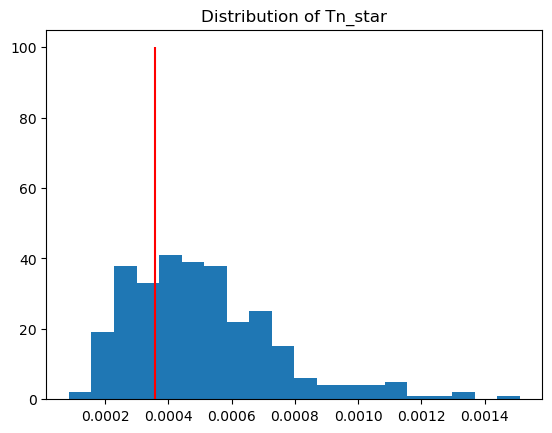

In [15]:
x = sampler(100, 100)[0][0]
y = sampler(100, 100)[0][0]

decision, Tn, Tn_star = phi_n_star(x, y, 300, .05)
plt.hist(Tn_star.reshape(1,300)[0], bins = 20)
plt.title("Distribution of Tn_star")
plt.vlines(Tn, 0, 100, colors = ["red"])
plt.show()

## Monte Carlo Simulationen
Wir wollen das Testverfahren für veschiendene Szenarien simulieren.

- Kann man die wahre Ablehnung durch eine zu hohe Bandbreite wegglätten?
- Wie verhalten sich die Powerfunktionen für verschiedene Gittergrößen?
- 

In [16]:
phi_n_star_monte_carlo = torch.vmap(lambda x, y: phi_n_star(x, y, 100, .05),
                                    randomness="different")

In [27]:
x, y = sampler(20, 20, 200), sampler(20, 20, 200)
decision, Tn, Tn_star = phi_n_star_monte_carlo(x[:, 0], y[:, 0])
decision.sum() / 200

tensor(0.)

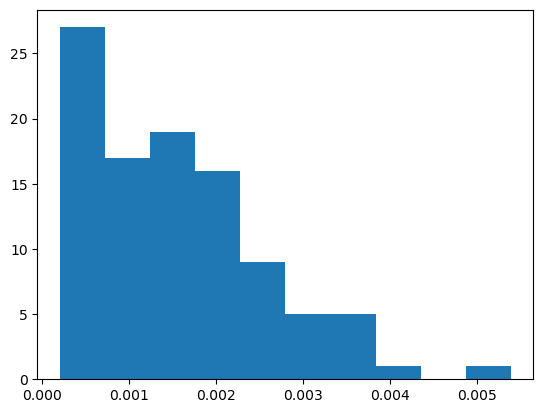

In [29]:
plt.hist(Tn_star[0].reshape(100))
plt.show()

In [31]:
# Monte Carlo under H0
# Bandwith of BP Kernel matters for the (true) size of the test
hs = torch.linspace(0.05, .5, 20)
N = 200
rejected_h0 = []
for h in hs:
  x = sampler(20, 20, N)
  y = sampler(20, 20, N)
  phi_n_star_monte_carlo = torch.vmap(lambda x, y: phi_n_star(x, y, 100, .05, hr = h, hc = h),
                                      randomness = "different")
  decision, Tn, Tn_star = phi_n_star_monte_carlo(x[:, 0], y[:, 0])
  rejected_h0.append(decision.sum() / N)

In [33]:
Tn_star

tensor([[[0.0026],
         [0.0005],
         [0.0005],
         ...,
         [0.0010],
         [0.0019],
         [0.0012]],

        [[0.0012],
         [0.0006],
         [0.0029],
         ...,
         [0.0025],
         [0.0007],
         [0.0007]],

        [[0.0007],
         [0.0017],
         [0.0002],
         ...,
         [0.0005],
         [0.0011],
         [0.0008]],

        ...,

        [[0.0035],
         [0.0004],
         [0.0029],
         ...,
         [0.0007],
         [0.0030],
         [0.0015]],

        [[0.0007],
         [0.0006],
         [0.0005],
         ...,
         [0.0011],
         [0.0005],
         [0.0012]],

        [[0.0038],
         [0.0018],
         [0.0007],
         ...,
         [0.0002],
         [0.0004],
         [0.0007]]])

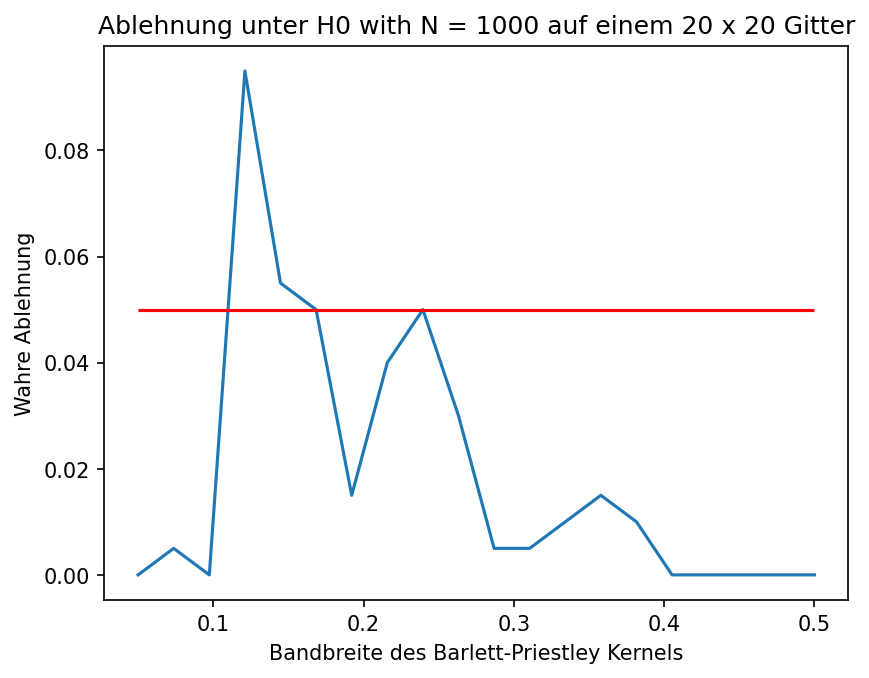

In [32]:
plt.figure(dpi = 150)
plt.plot(hs, rejected_h0)
plt.title("Ablehnung unter H0 with N = 1000 auf einem 20 x 20 Gitter")
plt.xlabel("Bandbreite des Barlett-Priestley Kernels")
plt.ylabel("Wahre Ablehnung")
plt.hlines([.05], .05, .5, colors = ["red"])
plt.show()

- Man sieht hier, dass für größere Bandbreiten die wahre Ablehnung gegen 0 geht
- Der test kann dann grenzwertige Spektraldichten nicht mehr auseinander halten

In [ ]:
# analysis of power
deltas = torch.linspace(0, .7, 20)
grid_sizes = [20, 25, 30, 40, 50]
N = 200
rejected = torch.zeros(5, 20)
i = 0
phi_n_star_monte_carlo = torch.vmap(lambda x, y: phi_n_star(x, y, 100, .05, hr = .18, hc = .18),
                                    randomness="different")

for grid_size in grid_sizes:
    j = 0
    for delta in deltas:
        K1 = torch.full((7, 7), delta)
        K1[3:6, 3:6] = K
        sampler1 = gridMA(K1)
        x = sampler1(grid_size, grid_size, N)
        y = sampler(grid_size, grid_size, N)
        decision, Tn, Tn_star = phi_n_star_monte_carlo(x[:, 0], y[:, 0])
        rejected[i, j] = decision.sum() / N
        j += 1
    i += 1
    

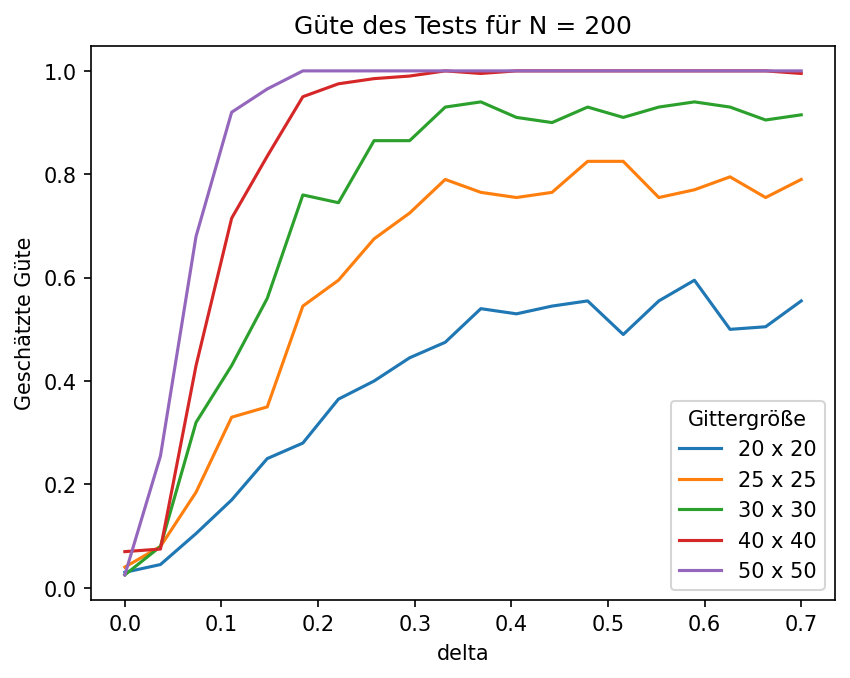

In [29]:
plt.figure(dpi = 150)
for i in range(rejected.shape[0]):
    plt.plot(deltas, rejected[i], label = f"{grid_sizes[i]} x {grid_sizes[i]}")
plt.title("Güte des Tests für N = 200")
plt.legend(title ="Gittergröße")
plt.ylabel("Geschätzte Güte")
plt.xlabel("delta")
plt.show()